In [1]:
import ncar_jobqueue

In [2]:
cluster = ncar_jobqueue.NCARCluster(
#    cores=9,  # The number of cores you want
    memory='600GB',  # Amount of memory
#    processes=9,  # How many processes
    walltime='02:00:00',  # Amount of wall time
    project="ncgd0011",  #Project id
)

cluster.scale(75)

/glade/u/home/pmora/.conda/envs/etpac/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33569 instead
  warnings.warn(


In [3]:
%matplotlib inline
%load_ext autoreload
%load_ext watermark

from etpac import annotate_stats
import dask
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
#import pandas as pd
import xarray as xr
#import xgcm
import cartopy.crs as cr
from cartopy import feature as cf

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 300

xr.set_options(keep_attrs=True, display_style="html")

%watermark -iv

xarray       : 0.18.2
json         : 2.0.9
cartopy      : 0.19.0.post1
matplotlib   : 3.5.3
sys          : 3.9.4 | packaged by conda-forge | (default, May 10 2021, 22:13:33) 
[GCC 9.3.0]
pandas       : 1.4.4
ncar_jobqueue: 2021.4.14
dask         : 2021.6.0
numpy        : 1.20.3
distributed  : 2021.6.0



In [10]:
client = distributed.Client(cluster)
client

Client Scheduler: tcp://10.12.206.53:44166 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/pmora/proxy/33569/status,Cluster Workers: 75 Cores: 150 Memory: 1.83 TiB


In [11]:
files = '/glade/campaign/cgd/oce/people/bachman/ETP_1_20_tides/HOURLY/ocean_hourly__*.nc'

In [12]:
DS = xr.open_mfdataset(
    files,
    compat="override",
    data_vars="minimal",
    coords="minimal",
    parallel=True,
    concat_dim="time",
    combine="nested",
    chunks={  "yq":200, "xh":200, },
)[["tauy"]]
#[["so", "thetao", "uo", "vo", "wo"]]

In [13]:
DS

,Array,Chunk
Bytes,764.96 GiB,3.66 MiB
Shape,"(227904, 901, 1000)","(24, 200, 200)"
Count,484296 Tasks,237400 Chunks
Type,float32,numpy.ndarray


In [14]:
tauy = DS['tauy']
tauy

,Array,Chunk
Bytes,764.96 GiB,3.66 MiB
Shape,"(227904, 901, 1000)","(24, 200, 200)"
Count,484296 Tasks,237400 Chunks
Type,float32,numpy.ndarray


In [27]:
A2_tauy = tauy.sel(xh=np.arange(260,283, 0.05), yq=np.arange(0,17, 0.05), method='nearest')
A2_tauy

/glade/u/home/pmora/.local/lib/python3.9/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.DataArray 'tauy' (time: 227904, yq: 340, xh: 460)>
dask.array<getitem, shape=(227904, 340, 460), dtype=float32, chunksize=(24, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * time     (time) datetime64[ns] 1992-12-30T01:00:00 ... 2018-12-30
  * yq       (yq) float64 0.0 0.05 0.1 0.15 0.2 ... 16.75 16.8 16.85 16.9 16.95
Attributes:
    units:          Pa
    long_name:      Meridional surface stress ocean interactions with atmos a...
    cell_methods:   yq:point xh:mean time: point
    standard_name:  surface_downward_y_stress
    interp_method:  none

In [ ]:
#Sesn_A2_tau = A2_tau.groupby('time.season').mean('time').persist()

In [28]:
month_A2_tauy = A2_tauy.groupby('time.month').mean('time').persist()

In [29]:
month_A2_tauy

<xarray.DataArray 'tauy' (month: 12, yq: 340, xh: 460)>
dask.array<stack, shape=(12, 340, 460), dtype=float32, chunksize=(1, 200, 200), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 260.0 260.1 260.1 260.2 ... 282.8 282.9 282.9 283.0
  * yq       (yq) float64 0.0 0.05 0.1 0.15 0.2 ... 16.75 16.8 16.85 16.9 16.95
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          Pa
    long_name:      Meridional surface stress ocean interactions with atmos a...
    cell_methods:   yq:point xh:mean time: point
    standard_name:  surface_downward_y_stress
    interp_method:  none

In [31]:
Epb= month_A2_taux*0.0000423887*86400
Epb

<xarray.DataArray 'taux' (month: 12, yh: 340, xq: 460)>
dask.array<mul, shape=(12, 340, 460), dtype=float64, chunksize=(1, 200, 460), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 0.025 0.075 0.125 0.125 ... 16.82 16.88 16.93 16.93
  * xq       (xq) float64 260.0 260.1 260.1 260.1 ... 282.8 282.9 282.9 282.9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          Pa
    long_name:      Zonal surface stress from ocean interactions with atmos a...
    cell_methods:   yh:mean xq:point time: point
    standard_name:  surface_downward_x_stress
    interp_method:  none

In [30]:
month_A2_tauy.to_netcdf('/glade/scratch/pmora/monthly_tauy.nc')

In [ ]:
Epb = Epb.to_netcdf('/glade/scratch/pmora/monthly_Ep_beta.nc')

In [ ]:
#Sesn_A2_tau.plot.contourf(xh='lon',yh='lat',col='season',col_wrap=2)

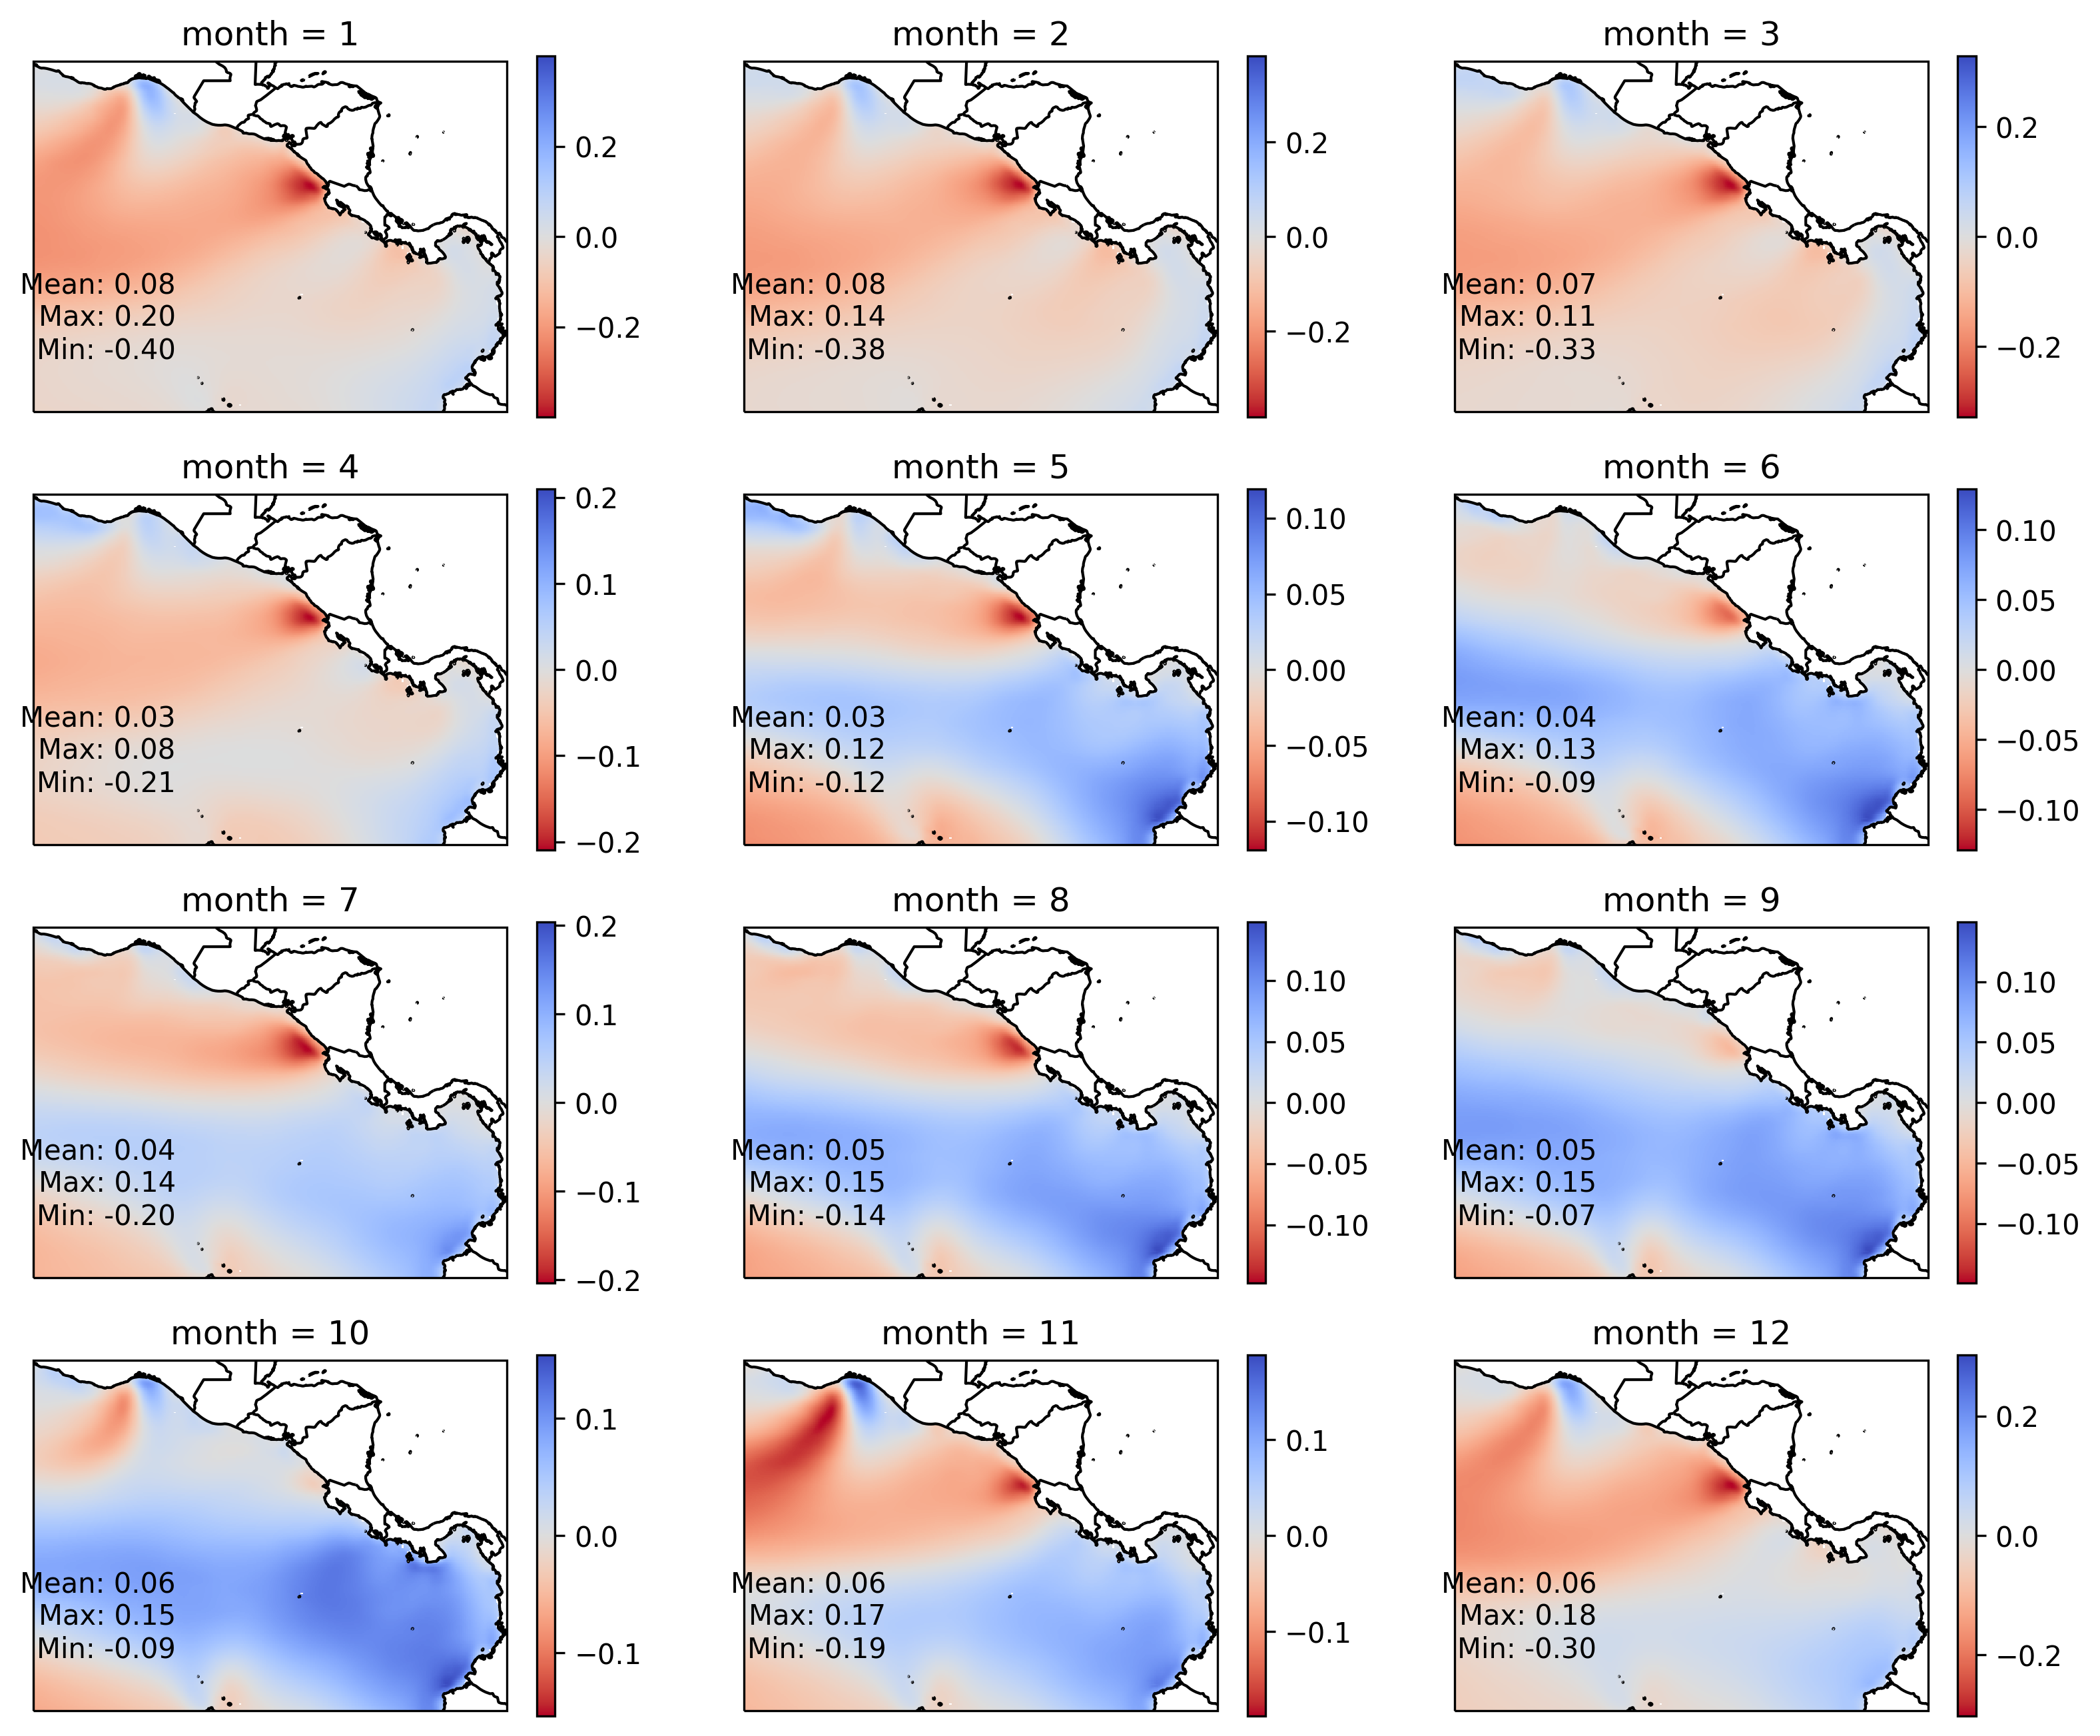

In [32]:
count = 0
fig=plt.figure(figsize=(13,11))
for month in Epb.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             Epb[Epb.month==month].plot(cmap="coolwarm_r", cbar_kwargs={"label": ""})
             annotate_stats(plt.gca(), Epb[Epb.month==month],  x=0.3, y=0.4)
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-100, -77, 0,17])
             
            
#             gl=ax.gridlines()
#             ax.xlabels_botton=True; ax.ylabels_left=True
#            gl.xformatter = LONGITUDE_FORMATTER
#             gl.yformatter = LATITUDE_FORMATTER

In [34]:
Epb2 = Epb.sel(xq=slice(272, 277), yh=slice(8, 13))              
Epb2

<xarray.DataArray 'taux' (month: 12, yh: 100, xq: 101)>
dask.array<getitem, shape=(12, 100, 101), dtype=float64, chunksize=(1, 100, 101), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 8.025 8.075 8.125 8.175 ... 12.82 12.88 12.93 12.98
  * xq       (xq) float64 272.0 272.1 272.1 272.1 ... 276.9 276.9 276.9 277.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:          Pa
    long_name:      Zonal surface stress from ocean interactions with atmos a...
    cell_methods:   yh:mean xq:point time: point
    standard_name:  surface_downward_x_stress
    interp_method:  none

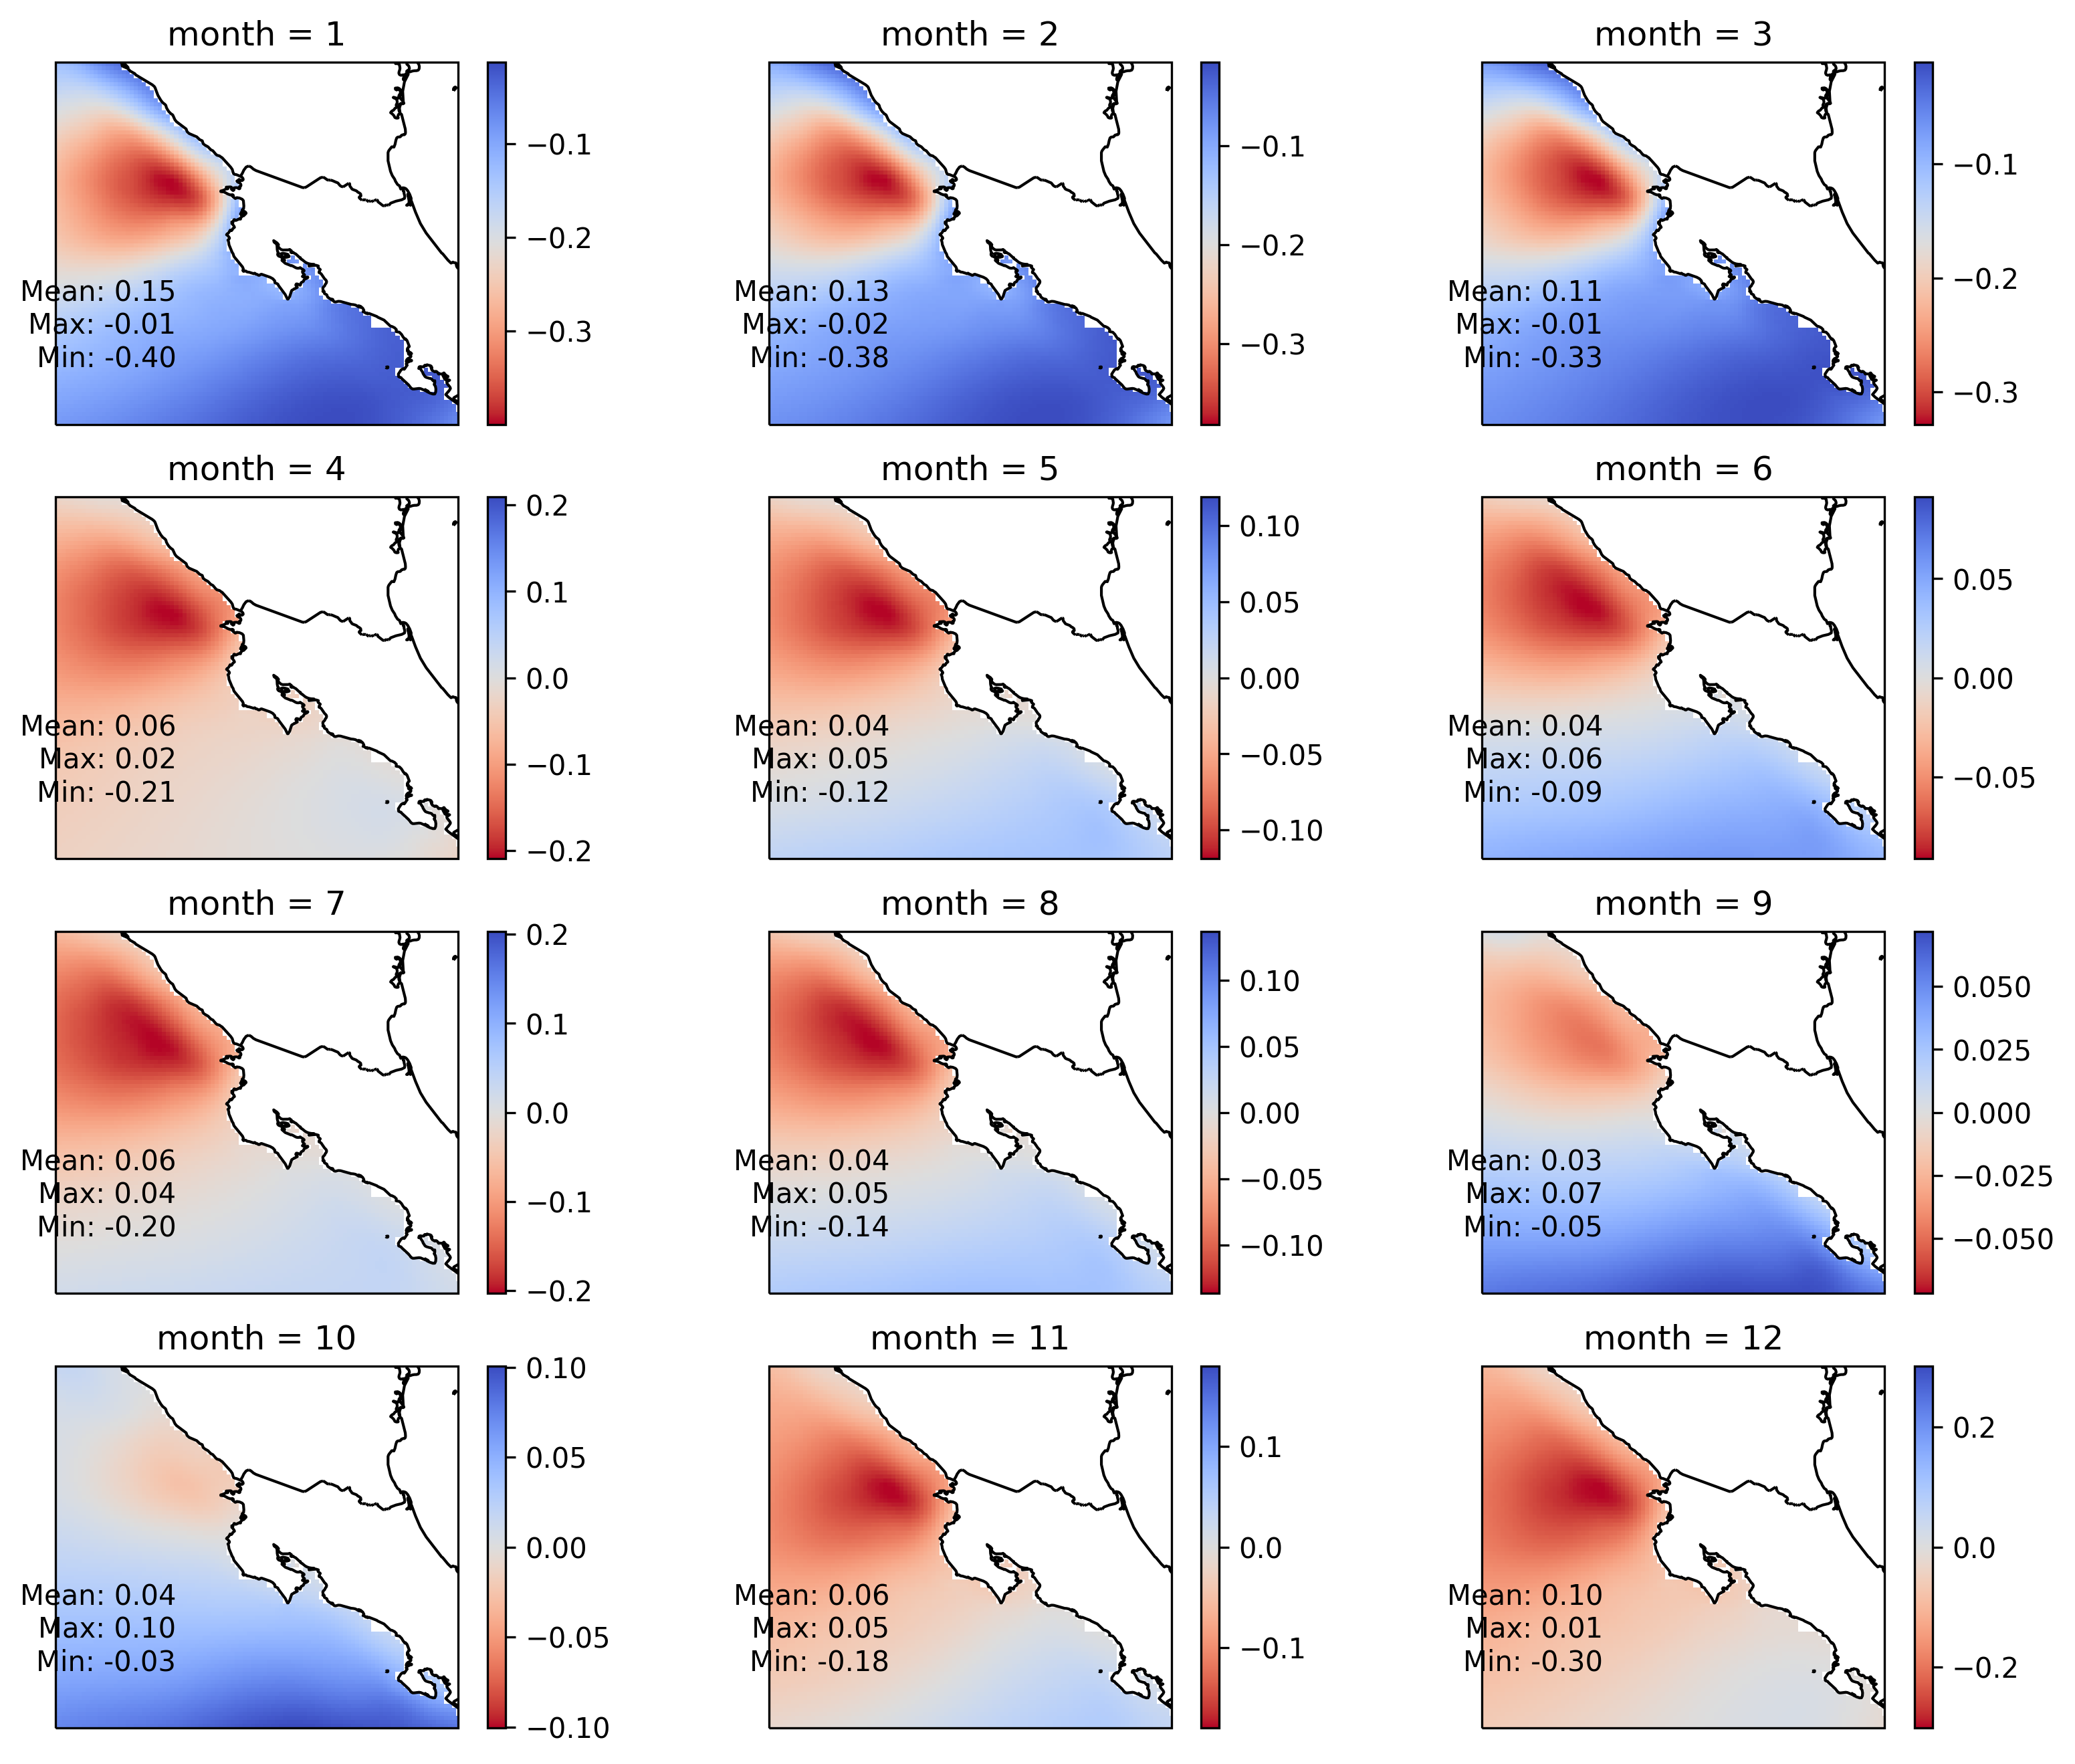

In [35]:
count = 0
fig=plt.figure(figsize=(13,11))
for month in Epb2.month:
             count+=1
             ax=fig.add_subplot(4,3,count,projection=cr.PlateCarree())
             Epb2[Epb2.month==month].plot(cmap="coolwarm_r", cbar_kwargs={"label": ""})
             annotate_stats(plt.gca(), Epb2[Epb2.month==month],  x=0.3, y=0.4)
             ax.coastlines(resolution='10m')
             ax.add_feature(cf.BORDERS)
             ax.set_extent([-88, -83, 8,12.5])
             
            
#             gl=ax.gridlines()
#             ax.xlabels_botton=True; ax.ylabels_left=True
#            gl.xformatter = LONGITUD-88, -83, 8,12.5E_FORMATTER
#             gl.yformatter = LATITUDE_FORMATTER

In [ ]:
Epb3 = Epb.sel(xq=slice(273, 275), yh=slice(9.5, 11.5))              
Epb3

In [31]:
client.close()
cluster.close()